In [1]:
#####無限次元潜在特徴モデル####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [3]:
####データの生成####
##データの設定
k = 10 
hh = 5000
item = 3000
Lambda = np.random.gamma(30.0, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)   #総サンプル数
k_vec = np.repeat(1, k)

In [4]:
##IDとインデックスを設定
#IDの設定
d_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
    
#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [5]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi_topic = np.random.dirichlet(np.repeat(0.25, item), topic)
theta_topic = np.random.dirichlet(np.repeat(0.3, topic), hh)
z = np.array(rmnom(theta_topic[d_id, ], hhpt, topic, np.arange(hhpt), 0), dtype="int")

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = rmnom(phi_topic[z[d_list[i]], ], pt[i], item, np.arange(pt[i]), 0)
    
#アイテムインデックスを作成
index = np.array(range(hhpt))
item_list = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")
    item_n[j] = item_list[j].shape[0]

0
1000
2000
3000
4000


In [6]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##モデルパラメータの生成
    #事前分布の設定
    alpha1 = np.array([0.0])
    alpha2 = np.repeat(0.0, k)
    tau_u = np.array([0.5])
    tau_v = np.array([0.5])
    Cov_u = np.diag(np.repeat(0.5, k))
    pi = np.random.beta(15.0, 22.5, k)
    taut_u = tau_u.copy(); taut_v = tau_v.copy()
    Covt_u = Cov_u.copy(); pit = pi.copy()

    #モデルパラメータの生成
    Sigma = np.array(0.5)
    beta = np.array(5.5, dtype="int")
    beta_u = np.random.normal(alpha1, tau_u, hh)
    beta_v = np.random.normal(alpha1, tau_v, item)
    theta_u = np.random.multivariate_normal(alpha2, Cov_u, hh)
    Z = np.zeros((item, k), dtype="int")
    for j in range(k):
        Z[:, j] = np.random.binomial(1, pi[j], item)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy()

    ##正規分布から応答変数を生成
    #モデルの期待値
    uv = np.dot(theta_u[d_id, ] * Z[item_id, ], k_vec)
    mu = beta + beta_u[d_id] + beta_v[item_id] + uv

    #データを生成
    U = np.random.normal(mu, Sigma, hhpt)

    #収束条件
    if (np.mean(U) < 6.0) & (np.mean(U) > 5.0) & (np.std(U) > 1.75) & (np.std(U) < 2.25):
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


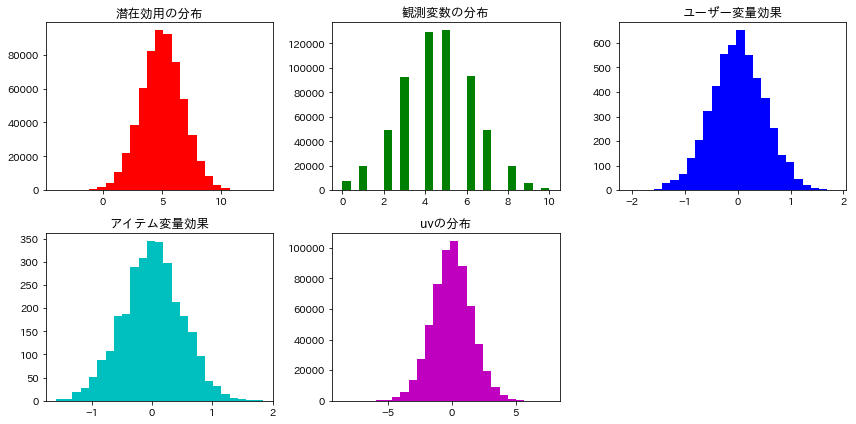

In [7]:
#応答変数の変換
y = np.array(U, dtype="int")
y[U > 10] = 10; y[U < 0] = 0

#生成したデータを可視化
dt = [U, y, beta_u, beta_v, uv]
fig_range = np.append(np.array([np.min(U), 0, np.min(beta_u), np.min(beta_v), np.min(uv)]), 
                      np.array([np.max(U), 10, np.max(beta_u), np.max(beta_v), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布", "観測変数の分布", "ユーザー変量効果", "アイテム変量効果", "uvの分布"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [8]:
####マルコフ連鎖モンテカルロ法でInfinite Latent Factor modelを推定####
##アルゴリズムの設定
k = 3
max_k = 15
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [9]:
##事前分布の設定
#IBPの集中度パラメータ
alpha = 1.0

#階層モデルのパラメータの事前分布
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)
nu = 1.0
V = 0.1 

#モデルパラメータの事前分布
tau = 100
s0 = 1.0
v0 = 1.0

In [10]:
##パラメータの初期値
#階層モデルの初期値
tau_u = np.array([0.25])
tau_v = np.array([0.25])
Cov_u = np.diag(np.repeat(0.1, k))
pi = np.repeat(0.25, k)

#モデルパラメータの初期値
beta = np.mean(y)
beta_u = np.random.normal(alpha1, tau_u, hh)
beta_v = np.random.normal(alpha1, tau_v, item)
theta_u = np.random.multivariate_normal(alpha2, Cov_u, hh)
Zi = np.zeros((item, k), dtype="int")
for j in range(k):
    Zi[:, j] = np.random.binomial(1, pi[j], item)
    
#モデルの期待値
uv = np.dot(theta_u[d_id, ] * Zi[item_id, ], np.repeat(1, k))
mu = beta + beta_u[d_id] + beta_v[item_id] + uv

In [12]:
####ギブスサンプリングでパラメータをサンプリング####

##期待値パラメータをサンプリング
#モデル誤差を定義
beta_user = beta_u[d_id]; beta_item = beta_v[item_id]
uv = np.dot(theta_u[d_id, ] * Zi[item_id, ], np.repeat(1, k))
er_y = y - beta_user - beta_item - uv

#正規分布から事後分布をサンプリング
weights = tau / (Sigma/hhpt + tau)
mu_par = weights * np.mean(er_y)
beta = np.random.normal(mu_par, np.sqrt(weights*Sigma/hhpt), 1)


##ユーザー変量効果をサンプリング
#モデル誤差を定義
er_y = y - beta - beta_item - uv

#ユーザーごとに事後分布をサンプリング
for i in range(hh):
    weights = tau_u / (Sigma/pt[i] + tau_u)
    mu_par = weights * np.mean(er_y[d_list[i]])
    beta_u[i] = np.random.normal(mu_par, np.sqrt(weights*tau_u/pt[i]))
beta_user = beta_u[d_id]
    

##アイテム変量効果をサンプリング
#モデル誤差を定義
er_y = y - beta - beta_user - uv

#アイテムごとに事後分布をサンプリング
for j in range(item):
    weights = tau_v / (Sigma/item_n[j] + tau_v)
    mu_par = weights * np.mean(er_y[item_list[j]])
    beta_v[j] = np.random.normal(mu_par, np.sqrt(weights*tau_v/item_n[j]))
beta_item = beta_v[item_id]

In [ ]:
##アイテム潜在特徴ベクトルをサンプリング
#